# Methods Notebook: Extracting Call Samples for KMeans Clustering

## Imports Section:

In [1]:
import numpy as np
import pandas as pd
import random
import scipy
from scipy import stats
import datetime as dt
import dask.dataframe as dd


import re
import suncalc
import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS, SEATTLE_LATITUDE, SEATTLE_LONGITUDE
import bout.assembly as bt
import bout.clustering as bt_clustering
import bout.plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as dh

import calls.compute_features as cf
import calls.call_extraction as cextract

from cli import get_file_paths

['/Users/adityakrishna/duty-cycle-investigation/daily_notebook', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python311.zip', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/lib-dynload', '', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/site-packages', '../src', '../src', '../src', '../src/bout', '../src', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src/bout', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src']


In [4]:
def convert_kaleidoscopedf_to_bd2df(df):
    bd2_df = pd.DataFrame()
    bd2_df['start_time'] = df['OFFSET']
    bd2_df['end_time'] = df['OFFSET'] + df['DURATION']
    bd2_df['low_freq'] = df['Fmin']
    bd2_df['high_freq'] = df['Fmax']
    bd2_df['input_file'] = df['IN FILE']
    bd2_df['input_dir'] = np.char.add(np.char.add(df['INDIR'].values.astype(str), '/'), df['FOLDER'].values.astype(str))
    bd2_df['mean_freq'] = df['Fmean']
    if 'TOP1MATCH*' in df.columns:
        bd2_df['TOP1MATCH*'] = df['TOP1MATCH*']
    if 'TOP1MATCH' in df.columns:
        bd2_df['TOP1MATCH'] = df['TOP1MATCH']
    bd2_df['TOP1DIST'] = df['TOP1DIST']
    bd2_df['TOP2MATCH'] = df['TOP2MATCH']
    bd2_df['TOP2DIST'] = df['TOP2DIST']
    bd2_df['TOP3MATCH'] = df['TOP3MATCH']
    bd2_df['TOP3DIST'] = df['TOP3DIST']
    bd2_df.sort_values('input_file', inplace=True)
    
    return bd2_df

def sort_file_group(file_group):
    return file_group.sort_values('start_time')

In [5]:
location_kd_df = dd.read_csv('../data/raw/Carp/kd_*.csv').compute()
location_kd_df

,INDIR,FOLDER,IN FILE,CHANNEL,OFFSET,DURATION,Fmin,Fmean,Fmax,DATE,...,TOP2DIST,TOP3MATCH,TOP3DIST,VOCALIZATIONS,MANUAL ID,ORGID,USERID,REVIEW ORGID,REVIEW USERID,INPATHMD5
0,/mnt,ubna_data_01_mir/recover-20220715/UBNA_008,20220713_010000.WAV,0,70.959251,0.004561,61157.797,72792.836,80128.203,2022-07-13,...,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,epEvrOgmZZnGiu7+zFOgUQ==
1,/mnt,ubna_data_01_mir/recover-20220715/UBNA_008,20220713_010000.WAV,0,77.038521,0.001000,74772.883,83963.656,92063.492,2022-07-13,...,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,epEvrOgmZZnGiu7+zFOgUQ==
2,/mnt,ubna_data_01_mir/recover-20220715/UBNA_008,20220713_010000.WAV,0,203.501175,0.001415,27681.992,28270.480,29198.637,2022-07-13,...,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,epEvrOgmZZnGiu7+zFOgUQ==
3,/mnt,ubna_data_01_mir/recover-20220715/UBNA_008,20220713_033000.WAV,0,404.457794,0.001121,31250.000,32100.697,32657.957,2022-07-13,...,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,C6Yvrk2WPLaPmpz3j5uC6A==
4,/mnt,ubna_data_01_mir/recover-20220715/UBNA_008,20220713_013000.WAV,0,459.950562,0.001084,24922.602,25840.555,28128.701,2022-07-13,...,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,calg11rwEEM5Y7P6uMTDvQ==
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22543,/mnt,ubna_data_02_mir/recover-20221017/UBNA_010,20221017_113000.WAV,0,880.261536,0.001685,52289.812,54596.273,58836.254,2022-10-17,...,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,9kp+ssTEUZYsqR3KTZwfmA==
22544,/mnt,ubna_data_02_mir/recover-20221017/UBNA_010,20221017_113000.WAV,0,880.470398,0.001997,44211.039,48069.121,51315.789,2022-10-17,...,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,9kp+ssTEUZYsqR3KTZwfmA==
22545,/mnt,ubna_data_02_mir/recover-20221017/UBNA_010,20221017_140000.WAV,0,757.142395,0.001498,10568.051,10678.930,10754.631,2022-10-17,...,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,WegExvWFwnkhFvCdSVfI0Q==
22546,/mnt,ubna_data_02_mir/recover-20221017/UBNA_010,20221017_140000.WAV,0,767.538147,0.001993,10004.002,10035.919,10102.041,2022-10-17,...,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,WegExvWFwnkhFvCdSVfI0Q==


In [6]:
location_df = convert_kaleidoscopedf_to_bd2df(location_kd_df)
location_df['file_group'] = location_df['input_file']
location_df = location_df.groupby('file_group', group_keys=False).apply(lambda x: sort_file_group(x))

location_df['start_time'] = location_df['start_time'].astype('float64')
location_df['end_time'] = location_df['end_time'].astype('float64')
location_df['low_freq'] = location_df['low_freq'].astype('float64')
location_df['high_freq'] = location_df['high_freq'].astype('float64')
file_dts = pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S', exact=False)
anchor_start_times = file_dts + pd.to_timedelta(location_df['start_time'], unit='S')
anchor_end_times = file_dts + pd.to_timedelta(location_df['end_time'], unit='S')

location_df.insert(0, 'call_end_time', anchor_end_times)
location_df.insert(0, 'call_start_time', anchor_start_times)
location_df.insert(0, 'ref_time', anchor_start_times)
location_df.reset_index(inplace=True)
location_df.rename({'index':'index_in_file'}, axis='columns', inplace=True)
location_df

,index_in_file,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,input_file,input_dir,mean_freq,TOP1MATCH,TOP1DIST,TOP2MATCH,TOP2DIST,TOP3MATCH,TOP3DIST,file_group
0,0,2022-07-13 01:01:10.959251,2022-07-13 01:01:10.959251,2022-07-13 01:01:10.963812,70.959251,70.963812,61157.797,80128.203,20220713_010000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,72792.836,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
1,1,2022-07-13 01:01:17.038521,2022-07-13 01:01:17.038521,2022-07-13 01:01:17.039521,77.038521,77.039521,74772.883,92063.492,20220713_010000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,83963.656,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
2,2,2022-07-13 01:03:23.501175,2022-07-13 01:03:23.501175,2022-07-13 01:03:23.502590,203.501175,203.502590,27681.992,29198.637,20220713_010000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,28270.480,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
3,5,2022-07-13 01:16:27.368286,2022-07-13 01:16:27.368286,2022-07-13 01:16:27.369423,987.368286,987.369423,10378.247,10612.768,20220713_010000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,10558.699,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
4,6,2022-07-13 01:19:59.530151,2022-07-13 01:19:59.530151,2022-07-13 01:19:59.532535,1199.530151,1199.532535,10025.062,10139.824,20220713_010000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,13422.763,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610510,22538,2022-10-17 13:40:29.671753,2022-10-17 13:40:29.671753,2022-10-17 13:40:29.673693,629.671753,629.673693,47065.336,57154.523,20221017_133000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,51536.633,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV
610511,22539,2022-10-17 13:42:52.847473,2022-10-17 13:42:52.847473,2022-10-17 13:42:52.848656,772.847473,772.848656,26405.229,27587.520,20221017_133000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,27048.941,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV
610512,22545,2022-10-17 14:12:37.142395,2022-10-17 14:12:37.142395,2022-10-17 14:12:37.143893,757.142395,757.143893,10568.051,10754.631,20221017_140000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,10678.930,nocluster,0,NaN,0,NaN,0,20221017_140000.WAV
610513,22546,2022-10-17 14:12:47.538147,2022-10-17 14:12:47.538147,2022-10-17 14:12:47.540140,767.538147,767.540140,10004.002,10102.041,20221017_140000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,10035.919,nocluster,0,NaN,0,NaN,0,20221017_140000.WAV


In [10]:
if not('freq_group' in location_df.columns):
    location_df.insert(0, 'freq_group', '')
groups = FREQ_GROUPS[data_params['site_tag']]
blue_group = groups['LF1']
red_group = groups['HF1']
yellow_group = groups['HF2']

call_is_yellow = (location_df['low_freq']>=yellow_group[0])&(location_df['high_freq']<=yellow_group[1])
call_is_red = (location_df['low_freq']>=red_group[0])&(location_df['high_freq']<=red_group[1])
call_is_blue = (location_df['low_freq']>=blue_group[0])&(location_df['high_freq']<=blue_group[1])

location_df.loc[call_is_yellow, 'freq_group'] = 'HF2'
location_df.loc[call_is_red&(~(call_is_yellow)), 'freq_group'] = 'HF1'
location_df.loc[call_is_blue&(~(call_is_red | call_is_yellow)), 'freq_group'] = 'LF1'
location_df

,freq_group,index_in_file,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,input_file,input_dir,mean_freq,TOP1MATCH,TOP1DIST,TOP2MATCH,TOP2DIST,TOP3MATCH,TOP3DIST,file_group
0,HF2,0,2022-07-13 01:01:10.959251,2022-07-13 01:01:10.959251,2022-07-13 01:01:10.963812,70.959251,70.963812,61157.797,80128.203,20220713_010000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,72792.836,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
1,HF2,1,2022-07-13 01:01:17.038521,2022-07-13 01:01:17.038521,2022-07-13 01:01:17.039521,77.038521,77.039521,74772.883,92063.492,20220713_010000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,83963.656,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
2,LF1,2,2022-07-13 01:03:23.501175,2022-07-13 01:03:23.501175,2022-07-13 01:03:23.502590,203.501175,203.502590,27681.992,29198.637,20220713_010000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,28270.480,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
3,,5,2022-07-13 01:16:27.368286,2022-07-13 01:16:27.368286,2022-07-13 01:16:27.369423,987.368286,987.369423,10378.247,10612.768,20220713_010000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,10558.699,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
4,,6,2022-07-13 01:19:59.530151,2022-07-13 01:19:59.530151,2022-07-13 01:19:59.532535,1199.530151,1199.532535,10025.062,10139.824,20220713_010000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,13422.763,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610510,HF2,22538,2022-10-17 13:40:29.671753,2022-10-17 13:40:29.671753,2022-10-17 13:40:29.673693,629.671753,629.673693,47065.336,57154.523,20221017_133000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,51536.633,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV
610511,LF1,22539,2022-10-17 13:42:52.847473,2022-10-17 13:42:52.847473,2022-10-17 13:42:52.848656,772.847473,772.848656,26405.229,27587.520,20221017_133000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,27048.941,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV
610512,,22545,2022-10-17 14:12:37.142395,2022-10-17 14:12:37.142395,2022-10-17 14:12:37.143893,757.142395,757.143893,10568.051,10754.631,20221017_140000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,10678.930,nocluster,0,NaN,0,NaN,0,20221017_140000.WAV
610513,,22546,2022-10-17 14:12:47.538147,2022-10-17 14:12:47.538147,2022-10-17 14:12:47.540140,767.538147,767.540140,10004.002,10102.041,20221017_140000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,10035.919,nocluster,0,NaN,0,NaN,0,20221017_140000.WAV


In [11]:
location_df.loc[(~(call_is_red | call_is_yellow | call_is_blue)), 'freq_group'] = np.NaN
location_df = location_df.loc[~location_df['freq_group'].isna()].copy()
location_df

,freq_group,index_in_file,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,input_file,input_dir,mean_freq,TOP1MATCH,TOP1DIST,TOP2MATCH,TOP2DIST,TOP3MATCH,TOP3DIST,file_group
0,HF2,0,2022-07-13 01:01:10.959251,2022-07-13 01:01:10.959251,2022-07-13 01:01:10.963812,70.959251,70.963812,61157.797,80128.203,20220713_010000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,72792.836,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
1,HF2,1,2022-07-13 01:01:17.038521,2022-07-13 01:01:17.038521,2022-07-13 01:01:17.039521,77.038521,77.039521,74772.883,92063.492,20220713_010000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,83963.656,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
2,LF1,2,2022-07-13 01:03:23.501175,2022-07-13 01:03:23.501175,2022-07-13 01:03:23.502590,203.501175,203.502590,27681.992,29198.637,20220713_010000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,28270.480,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
8,LF1,4,2022-07-13 01:37:39.950562,2022-07-13 01:37:39.950562,2022-07-13 01:37:39.951646,459.950562,459.951646,24922.602,28128.701,20220713_013000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,25840.555,nocluster,0,NaN,0,NaN,0,20220713_013000.WAV
11,LF1,3,2022-07-13 03:36:44.457794,2022-07-13 03:36:44.457794,2022-07-13 03:36:44.458915,404.457794,404.458915,31250.000,32657.957,20220713_033000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,32100.697,nocluster,0,NaN,0,NaN,0,20220713_033000.WAV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610508,HF2,22536,2022-10-17 13:40:28.351562,2022-10-17 13:40:28.351562,2022-10-17 13:40:28.352661,628.351562,628.352661,47919.656,55968.688,20221017_133000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,50958.004,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV
610509,HF2,22537,2022-10-17 13:40:28.546326,2022-10-17 13:40:28.546326,2022-10-17 13:40:28.547833,628.546326,628.547833,52343.484,62019.230,20221017_133000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,55728.887,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV
610510,HF2,22538,2022-10-17 13:40:29.671753,2022-10-17 13:40:29.671753,2022-10-17 13:40:29.673693,629.671753,629.673693,47065.336,57154.523,20221017_133000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,51536.633,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV
610511,LF1,22539,2022-10-17 13:42:52.847473,2022-10-17 13:42:52.847473,2022-10-17 13:42:52.848656,772.847473,772.848656,26405.229,27587.520,20221017_133000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,27048.941,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV


In [12]:
if data_params['type_tag']!='':
    location_df = location_df.loc[location_df['freq_group']==data_params['type_tag']]

In [13]:
cycle_length = int(data_params['cur_dc_tag'].split('of')[1])
time_on = int(data_params['cur_dc_tag'].split('of')[0])

location_df['ref_time'] = pd.DatetimeIndex(location_df['call_start_time'])
location_df['cycle_ref_time'] = pd.DatetimeIndex(location_df['call_start_time'])
location_df['call_end_time'] = pd.DatetimeIndex(location_df['call_end_time'])
location_df['call_start_time'] = pd.DatetimeIndex(location_df['call_start_time'])

resampled_cycle_length_df = location_df.resample(f'{cycle_length}T', on='cycle_ref_time', origin='start_day')
location_df['cycle_ref_time'] = pd.DatetimeIndex(resampled_cycle_length_df['cycle_ref_time'].transform(lambda x: x.name))

resampled_bin_df = location_df.resample(f'{data_params["bin_size"]}T', on='ref_time', origin='start_day')
location_df['ref_time'] = pd.DatetimeIndex(resampled_bin_df['ref_time'].transform(lambda x: x.name))

location_df.insert(0, 'end_time_wrt_ref', (location_df['call_end_time'] - location_df['cycle_ref_time']).dt.total_seconds())
location_df.insert(0, 'start_time_wrt_ref', (location_df['call_start_time'] - location_df['cycle_ref_time']).dt.total_seconds())
dc_applied_df = location_df.loc[(location_df['end_time_wrt_ref'] <= (60*time_on))&(location_df['start_time_wrt_ref'] >= 0)].copy()

In [14]:
dc_applied_df

,start_time_wrt_ref,end_time_wrt_ref,freq_group,index_in_file,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,...,input_dir,mean_freq,TOP1MATCH,TOP1DIST,TOP2MATCH,TOP2DIST,TOP3MATCH,TOP3DIST,file_group,cycle_ref_time
0,70.959251,70.963812,HF2,0,2022-07-13 01:00:00,2022-07-13 01:01:10.959251,2022-07-13 01:01:10.963812,70.959251,70.963812,61157.797,...,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,72792.836,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV,2022-07-13 01:00:00
1,77.038521,77.039521,HF2,1,2022-07-13 01:00:00,2022-07-13 01:01:17.038521,2022-07-13 01:01:17.039521,77.038521,77.039521,74772.883,...,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,83963.656,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV,2022-07-13 01:00:00
2,203.501175,203.502590,LF1,2,2022-07-13 01:00:00,2022-07-13 01:03:23.501175,2022-07-13 01:03:23.502590,203.501175,203.502590,27681.992,...,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,28270.480,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV,2022-07-13 01:00:00
8,459.950562,459.951646,LF1,4,2022-07-13 01:30:00,2022-07-13 01:37:39.950562,2022-07-13 01:37:39.951646,459.950562,459.951646,24922.602,...,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,25840.555,nocluster,0,NaN,0,NaN,0,20220713_013000.WAV,2022-07-13 01:30:00
11,404.457794,404.458915,LF1,3,2022-07-13 03:30:00,2022-07-13 03:36:44.457794,2022-07-13 03:36:44.458915,404.457794,404.458915,31250.000,...,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,32100.697,nocluster,0,NaN,0,NaN,0,20220713_033000.WAV,2022-07-13 03:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610508,628.351562,628.352661,HF2,22536,2022-10-17 13:30:00,2022-10-17 13:40:28.351562,2022-10-17 13:40:28.352661,628.351562,628.352661,47919.656,...,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,50958.004,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV,2022-10-17 13:30:00
610509,628.546326,628.547833,HF2,22537,2022-10-17 13:30:00,2022-10-17 13:40:28.546326,2022-10-17 13:40:28.547833,628.546326,628.547833,52343.484,...,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,55728.887,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV,2022-10-17 13:30:00
610510,629.671753,629.673693,HF2,22538,2022-10-17 13:30:00,2022-10-17 13:40:29.671753,2022-10-17 13:40:29.673693,629.671753,629.673693,47065.336,...,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,51536.633,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV,2022-10-17 13:30:00
610511,772.847473,772.848656,LF1,22539,2022-10-17 13:30:00,2022-10-17 13:42:52.847473,2022-10-17 13:42:52.848656,772.847473,772.848656,26405.229,...,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,27048.941,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV,2022-10-17 13:30:00


In [30]:
num_of_detections = dh.get_number_of_detections_per_interval(location_df.copy(), data_params)
activity_arr = dh.construct_activity_arr_from_location_summary(num_of_detections, data_params['cur_dc_tag'], data_params)
activity_arr.set_index('datetime_UTC', inplace=True)
activity_arr

,num_dets (30of30)
datetime_UTC,


In [17]:
file_params

{'ref_audio_files': [], 'good_audio_files': []}

In [18]:
activity_df = dh.construct_activity_grid_for_number_of_dets(activity_arr, data_params['cur_dc_tag'])

activity_times = pd.DatetimeIndex(activity_df.index).tz_localize('UTC')
activity_dates = pd.DatetimeIndex(activity_df.columns).strftime("%m/%d/%y")
ylabel = 'UTC'

activity_times = activity_times.strftime("%H:%M")
plot_times = [''] * len(activity_times)
plot_times[::3] = activity_times[::3]
plot_dates = [''] * len(activity_dates)
plot_dates[::7] = activity_dates[::7]

dates_for_sunrise_sunset = pd.to_datetime(activity_df.columns.values, format='%m/%d/%y')
activity_lat = [SEATTLE_LATITUDE]*len(dates_for_sunrise_sunset)
activity_lon = [SEATTLE_LONGITUDE]*len(dates_for_sunrise_sunset)
sunrise_time = pd.DatetimeIndex(suncalc.get_times(dates_for_sunrise_sunset, activity_lon, activity_lat)['sunrise_end'])
sunset_time = pd.DatetimeIndex(suncalc.get_times(dates_for_sunrise_sunset, activity_lon, activity_lat)['sunset_start'])
sunrise_seconds_from_midnight = sunrise_time.hour * 3600 + sunrise_time.minute*60 + sunrise_time.second
sunset_seconds_from_midnight = sunset_time.hour * 3600 + sunset_time.minute*60 + sunset_time.second
midnight_time = '07:00'


on = int(data_params['cur_dc_tag'].split('of')[0])
total = int(data_params['cur_dc_tag'].split('of')[1])
bin_size = int(data_params['bin_size'])
recover_ratio = min(total, bin_size) / min(on, bin_size)


masked_array_for_nodets = np.ma.masked_where(activity_df.values==np.NaN, activity_df.values)
cmap = plt.get_cmap('viridis')
cmap.set_bad(color='red')
plt.rcParams.update({'font.size': (0.6*len(activity_dates) + 0.6*len(activity_times))})
plt.figure(figsize=(0.9*len(activity_dates), 0.9*len(activity_times)))
title = f"{data_params['type_tag']} Activity (# of calls) from {data_params['site_name']}"
plt.title(title, fontsize=0.8*len(activity_dates) + 1.4*len(activity_times))
plt.imshow(1+(recover_ratio*masked_array_for_nodets), cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=10e3))
plt.plot(np.arange(0, len(plot_dates)), ((sunset_seconds_from_midnight / (30*60)) % len(plot_times)) - 0.5, 
        color='white', linewidth=0.5*len(activity_times), linestyle='dashed', label=f'Time of Sunset')
plt.axhline(y=np.where(activity_times==midnight_time)[0]-0.5, linewidth=0.5*len(activity_times), linestyle='dashed', color='white', label='Midnight 0:00 PST')
plt.plot(np.arange(0, len(plot_dates)), ((sunrise_seconds_from_midnight / (30*60)) % len(plot_times)) - 0.5, 
        color='white', linewidth=0.5*len(activity_times), linestyle='dashed', label=f'Time of Sunrise')
plt.yticks(np.arange(0, len(activity_df.index))-0.5, plot_times, rotation=30)
plt.xticks(np.arange(0, len(activity_df.columns))-0.5, plot_dates, rotation=30)
plt.ylabel(f'{ylabel} Time (HH:MM)')
plt.xlabel('Date (MM/DD/YY)')
plt.grid(which='both', linewidth=2)
# plt.legend(loc=3, ncol=3, fontsize=0.7*len(activity_dates) + 1*len(activity_times))
plt.colorbar()
plt.tight_layout()
plt.show()

/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_80943/2826560984.py:36: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(1+(recover_ratio*masked_array_for_nodets), cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=10e3))
/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_80943/2826560984.py:36: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(1+(recover_ratio*masked_array_for_nodets), cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=10e3))


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (0,).

/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/site-packages/matplotlib/axes/_base.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  fig_aspect = bb.height / bb.width


Error in callback <function _draw_all_if_interactive at 0x169fd6660> (for post_execute):


ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer

<Figure size 0x0 with 1 Axes>

In [ ]:
bd2_activity_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_dets_TYPE_SITE_summary"]}.csv', index_col=0)
bd2_activity_df = dh.construct_activity_grid_for_number_of_dets(bd2_activity_arr, data_params['cur_dc_tag'])
plt_activity_df = bd2_activity_df

activity_times = pd.DatetimeIndex(plt_activity_df.index).tz_localize('UTC')
activity_dates = pd.DatetimeIndex(plt_activity_df.columns).strftime("%m/%d/%y")
ylabel = 'UTC'

activity_times = activity_times.strftime("%H:%M")
plot_times = [''] * len(activity_times)
plot_times[::3] = activity_times[::3]
plot_dates = [''] * len(activity_dates)
plot_dates[::7] = activity_dates[::7]

dates_for_sunrise_sunset = pd.to_datetime(plt_activity_df.columns.values, format='%m/%d/%y')
activity_lat = [SEATTLE_LATITUDE]*len(dates_for_sunrise_sunset)
activity_lon = [SEATTLE_LONGITUDE]*len(dates_for_sunrise_sunset)
sunrise_time = pd.DatetimeIndex(suncalc.get_times(dates_for_sunrise_sunset, activity_lon, activity_lat)['sunrise_end'])
sunset_time = pd.DatetimeIndex(suncalc.get_times(dates_for_sunrise_sunset, activity_lon, activity_lat)['sunset_start'])
sunrise_seconds_from_midnight = sunrise_time.hour * 3600 + sunrise_time.minute*60 + sunrise_time.second
sunset_seconds_from_midnight = sunset_time.hour * 3600 + sunset_time.minute*60 + sunset_time.second
midnight_time = '07:00'


on = int(data_params['cur_dc_tag'].split('of')[0])
total = int(data_params['cur_dc_tag'].split('of')[1])
bin_size = int(data_params['bin_size'])
recover_ratio = min(total, bin_size) / min(on, bin_size)

masked_array_for_nodets = np.ma.masked_where(plt_activity_df.values==np.NaN, plt_activity_df.values)
cmap = plt.get_cmap('viridis')
cmap.set_bad(color='red')
plt.rcParams.update({'font.size': (0.6*len(activity_dates) + 0.6*len(activity_times))})
plt.figure(figsize=(0.9*len(activity_dates), 0.9*len(activity_times)))
title = f"{data_params['type_tag']} Activity (# of calls) from {data_params['site_name']}"
plt.title(title, fontsize=0.8*len(activity_dates) + 1.4*len(activity_times))
plt.imshow(1+(recover_ratio*masked_array_for_nodets), cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=10e3))
plt.plot(np.arange(0, len(plot_dates)), ((sunset_seconds_from_midnight / (30*60)) % len(plot_times)) - 0.5, 
        color='white', linewidth=0.5*len(activity_times), linestyle='dashed', label=f'Time of Sunset')
plt.axhline(y=np.where(activity_times==midnight_time)[0]-0.5, linewidth=0.5*len(activity_times), linestyle='dashed', color='white', label='Midnight 0:00 PST')
plt.plot(np.arange(0, len(plot_dates)), ((sunrise_seconds_from_midnight / (30*60)) % len(plot_times)) - 0.5, 
        color='white', linewidth=0.5*len(activity_times), linestyle='dashed', label=f'Time of Sunrise')
plt.yticks(np.arange(0, len(plt_activity_df.index))-0.5, plot_times, rotation=30)
plt.xticks(np.arange(0, len(plt_activity_df.columns))-0.5, plot_dates, rotation=30)
plt.ylabel(f'{ylabel} Time (HH:MM)')
plt.xlabel('Date (MM/DD/YY)')
plt.grid(which='both', linewidth=2)
# plt.legend(loc=3, ncol=3, fontsize=0.7*len(activity_dates) + 1*len(activity_times))
plt.colorbar()
plt.tight_layout()
plt.show()

/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_80913/2361597179.py:37: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(1+(recover_ratio*masked_array_for_nodets), cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=10e3))
/var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/ipykernel_80913/2361597179.py:37: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(1+(recover_ratio*masked_array_for_nodets), cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=10e3))


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (0,).

/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/site-packages/matplotlib/axes/_base.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  fig_aspect = bb.height / bb.width


Error in callback <function _draw_all_if_interactive at 0x17bf12660> (for post_execute):


ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer

<Figure size 0x0 with 1 Axes>

In [ ]:
selected_bd2_dates = bd2_activity_arr.loc[pd.DatetimeIndex(bd2_activity_arr.index)<dt.datetime(2022,11,1)]
selected_kd_dates = activity_arr.loc[pd.DatetimeIndex(activity_arr.index)<dt.datetime(2022,11,1)]

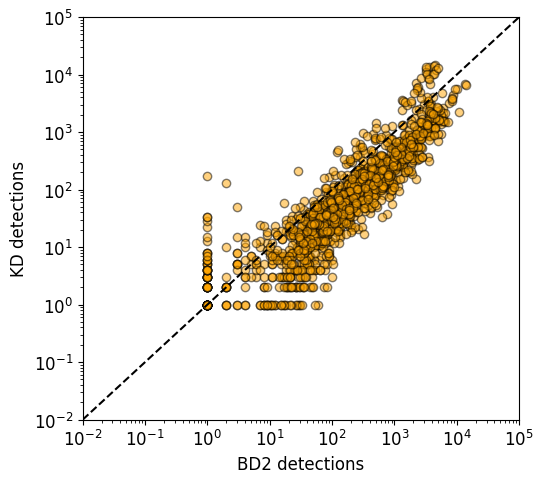

In [ ]:
plt.figure(figsize=(5.6,5))
plt.rcParams.update({'font.size':12})
plt.scatter(selected_bd2_dates.iloc[:,0], selected_kd_dates.iloc[:,0], facecolor='orange', edgecolor='black', alpha=0.5)
plt.plot([1e-2,1e5],[1e-2,1e5], linestyle='dashed', color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2, 1e5)
plt.ylim(1e-2, 1e5)
plt.xlabel("BD2 detections")
plt.ylabel("KD detections")
plt.tight_layout()
plt.show()

In [ ]:
def relabel_drivenames_to_mirrors(filepaths):
    drivename = re.compile(r'ubna_data_0[0-9]/')
    for i, fp in enumerate(filepaths):
        if bool(drivename.search(fp)):
            d_name = drivename.search(fp).group()
            replace_d_name = f'{d_name[:-1]}_mir/'
            filepaths[i] = filepaths[i].replace(d_name, replace_d_name)

    return filepaths

def get_params_relevant_to_data_at_location(cfg):
    data_params = dict()
    data_params["type_tag"] = ''
    data_params["cur_dc_tag"] = "1800of1800"
    data_params["site_tag"] = cfg['site']
    data_params['site_name'] = SITE_NAMES[cfg['site']]
    print(f"Searching for files from {data_params['site_name']}")

    file_paths = get_file_paths(data_params)
    location_sum_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
    location_sum_df.reset_index(inplace=True)
    location_sum_df.rename({'index':'index_in_file'}, axis='columns', inplace=True)
    location_sum_df.reset_index(inplace=True)
    location_sum_df.rename({'index':'index_in_summary'}, axis='columns', inplace=True)
    site_filepaths = relabel_drivenames_to_mirrors(location_sum_df['input_file'].copy().unique())
    bout_params = bt.get_bout_params_from_location(location_sum_df, data_params)

    data_params['good_audio_files'] = site_filepaths
    data_params['bout_params'] = bout_params
    print(f"Will be looking at {len(data_params['good_audio_files'])} files from {data_params['site_name']}")

    return location_sum_df, data_params

In [ ]:
print(f"Searching for files from {data_params['site_name']}")

file_paths = get_file_paths(data_params)
location_sum_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
location_sum_df

Searching for files from Carp Pond


,index_in_file,peak_frequency,index_in_summary,input_file_dt,freq_group,ref_time,call_start_time,call_end_time,start_time,end_time,...,event,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration
0,0,29760.0,0,2022-07-13 04:30:00,LF,2022-07-13 04:53:00.335500000,2022-07-13 04:53:00.335500000,2022-07-13 04:53:00.353200000,1380.3355,1380.3532,...,Echolocation,Nyctalus leisleri,0.487,0.559,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
1,1,24960.0,1,2022-07-13 04:30:00,LF,2022-07-13 04:55:13.597500000,2022-07-13 04:55:13.597500000,2022-07-13 04:55:13.612900000,1513.5975,1513.6129,...,Echolocation,Nyctalus leisleri,0.449,0.571,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
2,2,24960.0,2,2022-07-13 04:30:00,LF,2022-07-13 04:55:13.823500000,2022-07-13 04:55:13.823500000,2022-07-13 04:55:13.839600000,1513.8235,1513.8396,...,Echolocation,Nyctalus leisleri,0.513,0.591,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
3,3,26880.0,3,2022-07-13 04:30:00,LF,2022-07-13 04:55:13.988500000,2022-07-13 04:55:13.988500000,2022-07-13 04:55:14.001000000,1513.9885,1514.0010,...,Echolocation,Nyctalus leisleri,0.424,0.632,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
4,4,24960.0,4,2022-07-13 04:30:00,LF,2022-07-13 04:55:14.267500000,2022-07-13 04:55:14.267500000,2022-07-13 04:55:14.283900000,1514.2675,1514.2839,...,Echolocation,Nyctalus leisleri,0.459,0.587,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014238,72,25920.0,1016410,2022-10-17 13:30:00,LF,2022-10-17 13:42:57.365500000,2022-10-17 13:42:57.365500000,2022-10-17 13:42:57.377900000,777.3655,777.3779,...,Echolocation,Nyctalus leisleri,0.335,0.629,-1,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,Carp Pond,recover-20221017,10,1795.0
1014239,73,24960.0,1016411,2022-10-17 13:30:00,LF,2022-10-17 13:42:58.393500000,2022-10-17 13:42:58.393500000,2022-10-17 13:42:58.409200000,778.3935,778.4092,...,Echolocation,Nyctalus leisleri,0.518,0.615,-1,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,Carp Pond,recover-20221017,10,1795.0
1014240,74,25920.0,1016412,2022-10-17 13:30:00,LF,2022-10-17 13:42:58.543500000,2022-10-17 13:42:58.543500000,2022-10-17 13:42:58.558300000,778.5435,778.5583,...,Echolocation,Nyctalus leisleri,0.281,0.548,-1,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,Carp Pond,recover-20221017,10,1795.0
1014241,75,24960.0,1016413,2022-10-17 13:30:00,LF,2022-10-17 13:42:58.794500000,2022-10-17 13:42:58.794500000,2022-10-17 13:42:58.810800000,778.7945,778.8108,...,Echolocation,Nyctalus leisleri,0.534,0.630,-1,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,Carp Pond,recover-20221017,10,1795.0


In [ ]:
location_sum_df.reset_index(inplace=True)
location_sum_df.rename({'index':'index_in_file'}, axis='columns', inplace=True)
location_sum_df.reset_index(inplace=True)
location_sum_df.rename({'index':'index_in_summary'}, axis='columns', inplace=True)
location_sum_df

,index_in_summary,index_in_file,index_in_file,peak_frequency,index_in_summary,input_file_dt,freq_group,ref_time,call_start_time,call_end_time,...,event,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration
0,0,0,0,29760.0,0,2022-07-13 04:30:00,LF,2022-07-13 04:53:00.335500000,2022-07-13 04:53:00.335500000,2022-07-13 04:53:00.353200000,...,Echolocation,Nyctalus leisleri,0.487,0.559,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
1,1,1,1,24960.0,1,2022-07-13 04:30:00,LF,2022-07-13 04:55:13.597500000,2022-07-13 04:55:13.597500000,2022-07-13 04:55:13.612900000,...,Echolocation,Nyctalus leisleri,0.449,0.571,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
2,2,2,2,24960.0,2,2022-07-13 04:30:00,LF,2022-07-13 04:55:13.823500000,2022-07-13 04:55:13.823500000,2022-07-13 04:55:13.839600000,...,Echolocation,Nyctalus leisleri,0.513,0.591,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
3,3,3,3,26880.0,3,2022-07-13 04:30:00,LF,2022-07-13 04:55:13.988500000,2022-07-13 04:55:13.988500000,2022-07-13 04:55:14.001000000,...,Echolocation,Nyctalus leisleri,0.424,0.632,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
4,4,4,4,24960.0,4,2022-07-13 04:30:00,LF,2022-07-13 04:55:14.267500000,2022-07-13 04:55:14.267500000,2022-07-13 04:55:14.283900000,...,Echolocation,Nyctalus leisleri,0.459,0.587,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014238,1014238,1014238,72,25920.0,1016410,2022-10-17 13:30:00,LF,2022-10-17 13:42:57.365500000,2022-10-17 13:42:57.365500000,2022-10-17 13:42:57.377900000,...,Echolocation,Nyctalus leisleri,0.335,0.629,-1,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,Carp Pond,recover-20221017,10,1795.0
1014239,1014239,1014239,73,24960.0,1016411,2022-10-17 13:30:00,LF,2022-10-17 13:42:58.393500000,2022-10-17 13:42:58.393500000,2022-10-17 13:42:58.409200000,...,Echolocation,Nyctalus leisleri,0.518,0.615,-1,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,Carp Pond,recover-20221017,10,1795.0
1014240,1014240,1014240,74,25920.0,1016412,2022-10-17 13:30:00,LF,2022-10-17 13:42:58.543500000,2022-10-17 13:42:58.543500000,2022-10-17 13:42:58.558300000,...,Echolocation,Nyctalus leisleri,0.281,0.548,-1,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,Carp Pond,recover-20221017,10,1795.0
1014241,1014241,1014241,75,24960.0,1016413,2022-10-17 13:30:00,LF,2022-10-17 13:42:58.794500000,2022-10-17 13:42:58.794500000,2022-10-17 13:42:58.810800000,...,Echolocation,Nyctalus leisleri,0.534,0.630,-1,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,Carp Pond,recover-20221017,10,1795.0
